In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

## Gibbs sampler

We will first code a Gibbs Sampler for the model where $y=(y_1,\dots,y_n)$ are independent $\mathcal{N}(\mu,
\tau^{-1})$ random variables with both $\mu$ and $\tau$ unknown.

We will assign the $\mathcal{N}(0,\omega^{-1})$ prior on $\mu$ and the $Gamma(\alpha,\beta)$ prior on $\tau$.

### Activity 1
In the Gibbs sampling procedure, there will be two full conditional distributions from which we will want to sample, namely $p(\mu \mid y, \tau)$ and $p(\tau \mid y, \mu)$. Initially, prove

$$
\mu |y,\tau \sim \mathcal{N}\left(\frac{\tau}{n\tau + \omega}\sum y_{i},\frac{1}{n\tau + \omega}\right)
$$
and
$$
\tau|y,\mu \sim Gamma \left(\alpha + \frac{n}{2}, \beta+\frac{1}{2}\sum (y_{i}-\mu)^{2}\right)
$$
You can create a Markdown cell like the one below and write your proof there.

We start by writing he joint distribution for the model:  
$p(y, \mu, \tau) \propto \prod_{i=1}^{n} \exp\left(-\frac{\tau}{2}(y_i - \mu)^2\right) \times \exp\left(-\frac{\omega}{2}\mu^2\right) \times \tau^{\alpha-1} \exp(-\beta\tau)$



We start with the conditional distribution of µ.

We remove constants not related to µ

$  \exp\left(-\frac{\tau}{2}\sum_{i=1}^{n} (y_i - \mu)^2\right) \times \exp\left(-\frac{\omega}{2}\mu^2\right) $

We combine the two terms

$ \exp\left(-\frac{1}{2}\left(\tau\sum_{i=1}^{n} y_i^2 - 2\tau\sum_{i=1}^{n} y_i\mu + (n\tau + \omega)\mu^2\right)\right) $

We modify it to look like a normal distribution

$ \exp\left(-\frac{1}{2}\left(\tau\sum_{i=1}^{n} (y_i - \mu)^2 + \omega\mu^2\right)\right) $

And finally get the conditional:

$  \mu | y, \tau \sim \mathcal{N}\left(\frac{\tau}{n\tau + \omega}\sum_{i=1}^{n} y_{i}, \frac{1}{n\tau + \omega}\right) $

We start with the same joint distribution and remove constants not related to $\tau$

$ \tau^{\alpha-1} \exp(-\beta\tau) $

We combine  

$  \tau^{\alpha + \frac{n}{2} - 1} \exp\left(-\tau\left(\beta + \frac{1}{2}\sum_{i=1}^{n} (y_i - \mu)^2\right)\right) $

This expression is similar to a gamma distribution and re write it as: 

$ \tau | y, \mu \sim \text{Gamma}\left(\alpha + \frac{n}{2}, \beta + \frac{1}{2}\sum_{i=1}^{n} (y_i - \mu)^2\right) $

In [2]:
#Simulate data to check the Gibbs sampler
n = 100 #sample size
sigma_true = 2
sigma2_true = sigma_true**2
mu_true = 5
np.random.seed(4)
y = mu_true + np.random.randn(n)*sigma_true
ybar = np.mean(y)
S2 = np.sum((y-ybar)**2)

print('sample mean:',ybar)
print('sample variance:',S2/(n-1))

sample mean: 5.070547155947767
sample variance: 3.8244883511126635


Implement the Gibbs sampler in the following cell and check posterior traceplots of mean and variance and compare them with true values.

In [9]:
def sample_conditional_mu(y, tau, w, n):
    new_mean = (tau/(n*tau+w))*sum(y)
    new_sigma = 1/(n*tau+w)
    new_mu = np.random.normal(new_mean,np.sqrt(new_sigma),1)
    return new_mu

def sample_conditional_tau(alpha, beta, n, y, mu):
    pass


def gibbs_sampling():
    pass



### Activity 2
Repeat for the model below

$$
y_i\sim \text{Poisson}(\mu), \;\;i=1,...,N,
$$
with priors 
$$
\mu \sim \text{Gamma}(2,\beta),\;\;
\beta \sim \text{Exponential}(1)
$$


$$
\mu| y,\beta \;\sim\;\text{Gamma}(2 + \sum_i y_i,n+\beta)
$$
$$
\beta|y,\mu\;\sim \;\text{Gamma}(3,1+\mu)
$$

#Mathematical proof


In [2]:
#Python code


## Mean Field approximation 

We will first simulate $100$ independent observations from the model 

$$
y\sim N(\mu, \tau^{-1})
$$

with $\mu=5$ and $\tau^{-1}=0.5$.

Treat $\mu$ and $\tau^{-1}$ as unknown and  use the mean field approximation algorithm presented in the lecture to estimate them.

#### Simulate Data

In [4]:
#Set parameters and simulate data
n = 100
mu = 3
tau = 2
std = np.sqrt(1/tau)
y = mu + std*np.random.randn(n)

#Set prior hyperparameters
mu0 = 0
lam0 = 1 #unit information prior
a0 = 0.001
b0 = 0.001


# get sufficient stats
Sy = np.sum(y)
Sy2 = np.sum(y**2)
m02 = mu0**2

### Activity 3
Implement the algorithm

Let $y=(y_1, \dots, y_n)$ be independent Poisson($\lambda$) observations. Assume that $\lambda$ follows the Gamma($2,\beta$) distribution, where $\beta$ follows the Exponential($1$) distribution. The aim is to draw inference from the posterior $\pi(\theta|y)$, where $\theta=(\lambda, \beta)$. 

In [5]:
#Set parameters and simulate data
n = 100
np.random.seed(1)
beta_true = np.random.exponential(1,1)
lambda_true  = np.random.gamma(2,1/beta_true,1)
print('beta value: ',beta_true,' lambda value: ',lambda_true)
y = np.random.poisson(lambda_true,n)

# get sufficient stats
sy = np.sum(y)
print('ybar: ',sy/n)

beta value:  [0.53960584]  lambda value:  [1.53955169]
ybar:  1.41


The variational Bayes algorithm **approximates** $\pi(\theta|y)$ using the mean field approximation 

$$
q(\theta|y, \phi)=q(\lambda|y, \phi)q(\beta|y, \phi)
$$

It can be shown (see exam paper of 2019, question 2a) that such an algorithm may consist of the following steps

 1. Initialise at $q(\lambda)$ to be the Gamma($a_{\lambda},b_{\lambda}$) and $q(\beta)$ to be the Gamma($a_{\beta},b_{\beta}$) distribution, setting $$a_{\lambda}=2+\sum_iy_i,\;\; b_{\lambda}=b_{\lambda}^0,\;\;\;a_{\beta}=3,\;\text{ and }\;\;b_{\beta}=b_{\beta}^0. $$
 2. Iteratively update $b_{\lambda}$ and $b_{\beta}$ until the parameters or the ELBO converge. At iteration $i$ will have:
 
    a. Set $$b_{\lambda}^{i}=n+\mathbb{E}_{q(\beta)}[\beta]=n+3/b_{\beta}^{i-1}$$
    
    b. Set $$b_{\beta}^{i}=1+\mathbb{E}_{q(\lambda)}[\lambda]=1+(2+\sum_iy_i)/b_{\lambda}^{i}$$

### Activity 4
Code the above algorithm and fit it to the simulated data. Check your answers in terms of the lambda estimates.

Put your code below

## Image denosing with Gibbs sampling

Text(0.5, 1.0, 'True binary image')

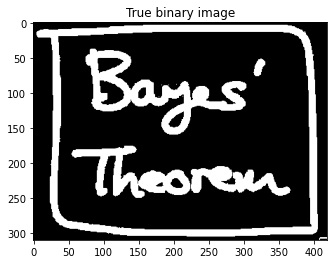

In [6]:
#load image data
data = Image.open('bayes.bmp')
temp = np.double(data)
temp_mean = np.mean(data)
clean_img = +1*(temp>temp_mean) + -1*(temp<temp_mean)

plt.figure()
plt.imshow(clean_img,cmap='Greys')
plt.title("True binary image")

310 419


Text(0.5, 1.0, 'observed noisy image')

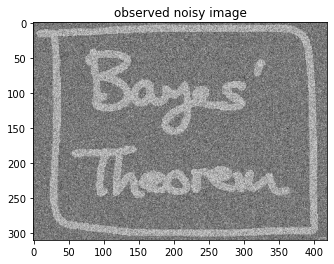

In [7]:
height,width = clean_img.shape
print(height,width)
sigma  = 1  #noise level
noisy_img = clean_img + sigma*np.random.randn(height, width)
plt.figure()
plt.imshow(noisy_img, cmap='Greys')
plt.title("observed noisy image")

### Activity 5
Implement Gibbs sampler for Ising model presented in the lecture to denoise the image. Comapre denoised image with the original image.


Initialization: $\{x_i : i = 1, \ldots, M\}$ to some initial values $\{x^{(1)}_i\}$, e.g., $x^{(1)}_i = +1$ and $x^{(1)}_i = -1$ with probability $\frac{1}{2}$.

For $\tau = 1, \ldots, T$ repeat:


1. Sample $x^{(\tau+1)}_1 \sim p(x_1 | x^{(\tau)}_2, x^{(\tau)}_3, \ldots, x^{(\tau)}_M, y_1)$
2. Sample $x^{(\tau+1)}_2 \sim p(x_2 | x^{(\tau+1)}_1, x^{(\tau)}_3, \ldots, x^{(\tau)}_M, y_2)$
   
   $\vdots$

. Sample $x^{(\tau+1)}_M \sim p(x_M | x^{(\tau+1)}_1, x^{(\tau+1)}_2, \ldots, x^{(\tau+1)}_{M-1}, y_M)$


$$
p(x_i = +1 | x_{\setminus i}, y) = \frac{\exp\left(\beta \sum_{j \in N(i)} x_j + \eta y_i\right)}{\exp\left(\beta \sum_{j \in N(i)} x_j + \eta y_i\right) + \exp\left(-\beta \sum_{j \in N(i)} x_j - \eta y_i\right)} = \sigma\left(2\left(\eta y_i + \beta \sum_{j \in N(i)} x_j\right)\right)
$$


Try different noise levels and plot the normalized mean squared error (NMSE) vs noise level.


Try different parameters in the energy function, e.g., $ \beta, \eta$, and  plot the following figures.
1. NMSE vs $ \beta$
2. NMSE vs $ \eta$

## Image denosing with Mean-field approximation

Now, we try to apply mean-field approximation to denoise the image.
The posterior for Ising model has the following form
$$P(x\mid y) = \frac{1}{Z}exp(-E(x))$$
where
$$E(x) = E_{0}(x) - \sum_{i}L_{i}(x_{i}) \;\;\;\;\;\; E_{0}(x) = - \beta\sum_{i,j}x_{i}x_{j},\;\;\;  L_{i}(x_{i}) = \eta\sum_{i}x_{i}y_{i}$$
In mean-field approximation, we try to approximate this posterior by a fully factored approximation
$$q(x) = \prod_{i}q(x_{i}, \mu_{i})$$
where $\mu_{i}$ is the mean value of node $i$. To derive the update for the variational parameter $\mu_{i}$, we
first write out $log\tilde{p}(x) = -E(x)$, dropping terms that do not involve $x_{i}$:
$$log\tilde{p}(x) = \beta x_{i} \sum_{j}x_{j} + L_{i}(x_{i}) + const$$
This only depends on the states of the neighboring nodes. Now we take expectations of this wrt
$ \prod_{j\neq i}q(x_{i})$ to get
$$q(x_{i}) \propto exp(x_{i}\sum_{j}\beta \mu_{j} + L_{i}(x_{i})) $$
Thus we replace the states of the neighbors by their average values. Let
$$ m_{i} = \sum_{j} \beta \mu_{j} $$
be the mean field influence on node $i$. Also, let $L_{i}^{+}=L_{i}(1)$ and $L_{i}^{-}=L_{i}(-1)$. The
approximate marginal posterior is given by
$$q_{i}(x_{i}=1)=\frac{exp(m_{i}+L_{i}^{+})}{exp(m_{i}+L_{i}^{+})+exp(-m_{i}+L_{i}^{-})}=sigm(2a_{i}),\;\;\;\;\;\;a_{i}=m_{i}+0.5(L_{i}^{+}-L_{i}^{-})  $$
Similarly, we have $q_{i}(x_{i}=-1) = sigm(-2a_{i})$. From this we can compute the new mean for
site $i$:
$$\mu_{i} = \mathbb{E}_{q_{i}}[x_{i}] = tanh(a_{i})$$
Hence the update equation becomes
$$\mu_{i} = \mathbb{E}_{q_{i}}[x_{i}] =q_{i}(x_{i}=+1)(+1) + q_{i}(x_{i}=-1)(-1) = tanh(a_{i})$$
Hence the update equation becomes
$$\mu_{i} = tanh(\sum_{j} \beta \mu_{j}+0.5(L_{i}^{+}-L_{i}^{-}) )$$
We can turn the above equations in to a fixed point algorithm by writing
$$\mu_{i}^{t} = tanh(\sum_{j} \beta \mu_{j}^{t-1}+0.5(L_{i}^{+}-L_{i}^{-}) )$$
It is usually better to use damped updates of the form
$$\mu_{i}^{t} = (1-\lambda)\mu_{j}^{t-1} + \lambda tanh(\sum_{j} \beta \mu_{j}^{t-1}+0.5(L_{i}^{+}-L_{i}^{-}) ) ,\;\;\;\;\;\; 0<\lambda<1$$

### Activity 6
Write your code below to denoise the image using mean-field approximation and draw the same plots as image denoising using Gibbs sampling.

### Activity 7
Compare the NMSE of the denoising schemes that you have implemented here and the previous Python lab, e.g., ICM, Gibbs sampling, and mean-field approximation.